# Proyecto Final - Clasificación de Cáncer de Piel con Redes Neuronales
Entrenamiento y comparación de modelos preentrenados usando el dataset HAM10000 en Google Colab.

CARGA Y EXTRACCION DE DATOS

In [1]:
#mMontaje a google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/Proyecto_Cancer_Piel/data.zip" #define la ruta del archivo que contiene el dataset
extract_path = "/content/Proyecto_Cancer_Piel" #ruta de destino donde se extraeran los archivos

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Archivos extraídos correctamente.")

Archivos extraídos correctamente.


IMPORTACION DE LIBRERIAS

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

DEFINICION DEL DATASET PERSONALIZADO


In [4]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filename = self.dataframe.loc[idx, 'path']
        img_path = os.path.join(self.root_dir, filename)
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.loc[idx, 'label'])
        if self.transform:
            image = self.transform(image)
        return image, label

TRANSFORMACIONES PARA PREPROCESAMIENTO DE IMAGENES

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

CREACION DE DATASET Y DATALOADER

In [6]:
#Carga y limpieza del .CSV
df_path = "/content/Proyecto_Cancer_Piel/data/training_data.csv"
df = pd.read_csv(df_path)

# Limpiar la columna 'path' para que tenga solo el nombre del archivo
df['path'] = df['path'].apply(lambda p: os.path.basename(str(p).replace('\\', '/')))




from sklearn.model_selection import train_test_split
#Split entre entrenamiento y validacion
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

img_dir = "/content/Proyecto_Cancer_Piel/data/HAM10000_images"

#Creacion de dataset
train_dataset = SkinCancerDataset(train_df, root_dir=img_dir, transform=transform_train)
val_dataset = SkinCancerDataset(val_df, root_dir=img_dir, transform=transform_val)
#Creacion de dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

DEFINICION DE MODELOS PREENTRENADOS CON FINE TUNING

In [7]:
def get_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) #Carga la arquitectura ResNet50 preentrenada en ImageNet
        model.fc = nn.Linear(model.fc.in_features, num_classes) #Sobrescribe la última capa totalmente conectada fc del modelo para que se adapte al problema. Así, se reemplaza la salida original de 1000 clases de ImageNet por 7 clases para nuestro dataset.
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes) # Reemplaza la última capa del clasificador de MobileNetV2 con una nueva capa Linear que tenga salida para num_classes. Model.classifier es una secuencia de capas, y [1] apunta a la capa final Linear.
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes) #Mismo caso que para MobileNet.
    else:
        raise ValueError("Modelo no soportado")
    return model.to(device)

ENTRENAMIENTO Y VALIDACION DEL MODELO

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, model_name, epochs=5):
    criterion = nn.CrossEntropyLoss() # Se usa CrossEntropyLoss ya que es una tarea de clasificación multiclase
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # El optimizador Adam ajusta los parámetros entrenables del modelo. model.parameters() incluye los pesos preentrenados, no congela ninguno.
    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # Se pasan las imágenes y etiquetas al dispositivo. Se hace forward pass, se calcula la pérdida, se realiza el backpropagation y se actualizan los pesos.
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # Calcula los gradientes
            optimizer.step()  # Actualiza los pesos del modelo. Ajusta los pesos en base al error
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        #Se evalúa el modelo sin actualizar los pesos, se acumula la pérdida y se mide la precisión sobre el conjunto de validación
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        #calculo de metricas y validacion
        val_loss /= len(val_loader)
        val_acc = correct / total

        #registro de metricas por epoca
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    #guardado del modelo y metricas
    os.makedirs("results", exist_ok=True)
    df = pd.DataFrame(history)
    df.to_csv(f"results/{model_name}_metrics.csv", index=False)
    torch.save(model.state_dict(), f"results/{model_name}.pth")
    return df

def plot_metrics(df, model_name):
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
    plt.plot(df["epoch"], df["val_loss"], label="Val Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(df["epoch"], df["val_acc"], label="Val Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Nombres de las clases ordenadas por su índice
class_names = [
    "Nevus melanocítico",        # nv
    "Melanoma",                  # mel
    "Lesiones tipo queratosis",  # bkl
    "Carcinoma basocelular",     # bcc
    "Queratosis actínica",       # akiec
    "Lesiones vasculares",       # vasc
    "Dermatofibroma"             # df
]

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np

def evaluate_model(model, data_loader, model_name, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    y_probs = np.concatenate(all_probs)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de confusión - {model_name}")
    plt.show()

    # Reporte de clasificación
    print(f"Reporte de clasificación para {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # AUC-ROC macro
    try:
        y_true_bin = np.eye(len(class_names))[y_true]
        auc_macro = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
        print(f"AUC ROC macro promedio para {model_name}: {auc_macro:.4f}")
        # Curva ROC para cada clase
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            plt.plot(fpr, tpr, label=f"{class_name}")
        plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
        plt.title(f"Curva ROC - {model_name}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.grid()
        plt.show()
    except Exception as e:
        print("No se pudo calcular ROC AUC:", e)

    return classification_report(y_true, y_pred, target_names=class_names, output_dict=True)


ENTRENAMIENTO Y VALIDACION DE LA RED NEURONAL


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


Epoch 1/20 - Train Loss: 0.8771 - Val Loss: 0.5980 - Val Acc: 0.7854
Epoch 2/20 - Train Loss: 0.4990 - Val Loss: 0.4963 - Val Acc: 0.8266
Epoch 3/20 - Train Loss: 0.3726 - Val Loss: 0.4511 - Val Acc: 0.8478
Epoch 4/20 - Train Loss: 0.2723 - Val Loss: 0.4508 - Val Acc: 0.8453
Epoch 5/20 - Train Loss: 0.2046 - Val Loss: 0.4560 - Val Acc: 0.8503
Epoch 6/20 - Train Loss: 0.1618 - Val Loss: 0.4846 - Val Acc: 0.8503
Epoch 7/20 - Train Loss: 0.1138 - Val Loss: 0.4443 - Val Acc: 0.8677
Epoch 8/20 - Train Loss: 0.0975 - Val Loss: 0.4795 - Val Acc: 0.8546
Epoch 9/20 - Train Loss: 0.0819 - Val Loss: 0.4996 - Val Acc: 0.8646
Epoch 10/20 - Train Loss: 0.0627 - Val Loss: 0.5432 - Val Acc: 0.8659
Epoch 11/20 - Train Loss: 0.0556 - Val Loss: 0.5182 - Val Acc: 0.8584
Epoch 12/20 - Train Loss: 0.0555 - Val Loss: 0.5336 - Val Acc: 0.8690
Epoch 13/20 - Train Loss: 0.0455 - Val Loss: 0.5652 - Val Acc: 0.8709
Epoch 14/20 - Train Loss: 0.0491 - Val Loss: 0.5436 - Val Acc: 0.8715
Epoch 15/20 - Train Loss: 0.0

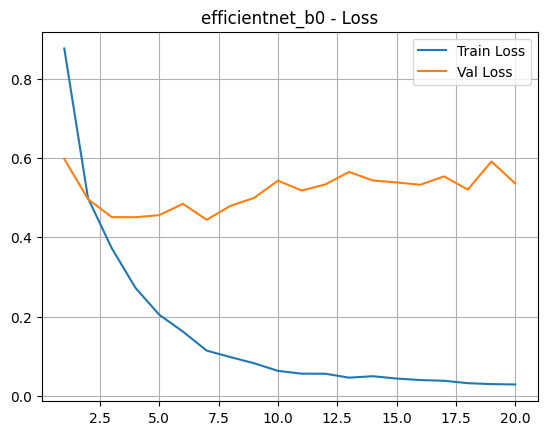

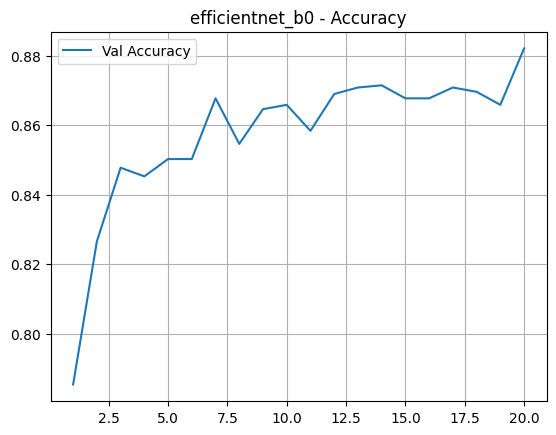

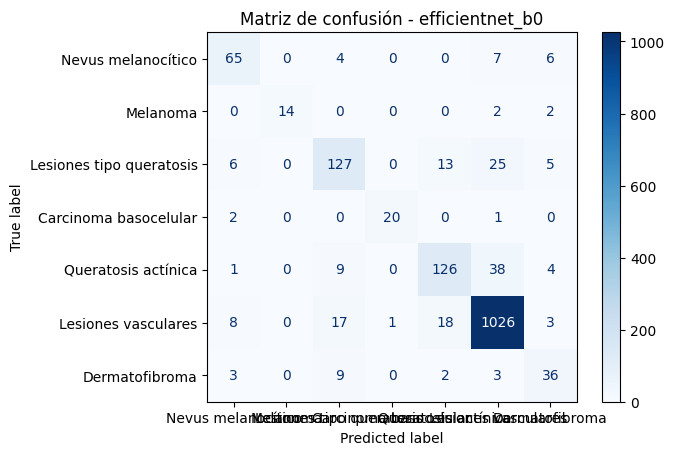

Reporte de clasificación para efficientnet_b0:

                          precision    recall  f1-score   support

      Nevus melanocítico       0.76      0.79      0.78        82
                Melanoma       1.00      0.78      0.88        18
Lesiones tipo queratosis       0.77      0.72      0.74       176
   Carcinoma basocelular       0.95      0.87      0.91        23
     Queratosis actínica       0.79      0.71      0.75       178
     Lesiones vasculares       0.93      0.96      0.94      1073
          Dermatofibroma       0.64      0.68      0.66        53

                accuracy                           0.88      1603
               macro avg       0.84      0.79      0.81      1603
            weighted avg       0.88      0.88      0.88      1603

AUC ROC macro promedio para efficientnet_b0: 0.9779


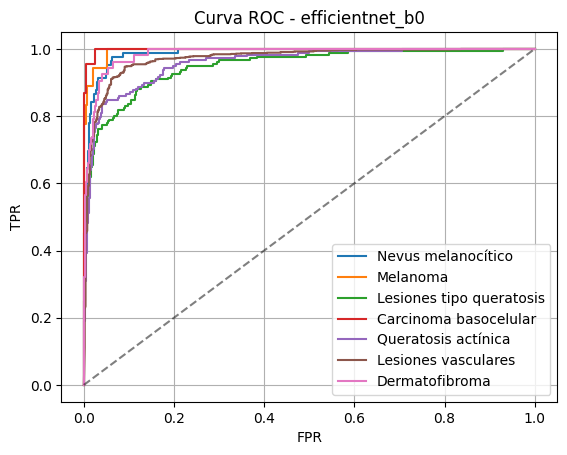

In [11]:
model_name = 'efficientnet_b0'
model = get_model(model_name, num_classes=7)
df_efficientnet = train_model(model, train_loader, val_loader, model_name, epochs=20)
plot_metrics(df_efficientnet, model_name)
report_efficientnet = evaluate_model(model, val_loader, model_name, class_names)


In [ ]:
# Guardar modelo y métricas
torch.save(model.state_dict(), "efficientnet_b0.pth")
df_efficientnet.to_csv("efficientnet_b0_metrics.csv", index=False)

In [ ]:
from google.colab import files
files.download('efficientnet_b0.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 205MB/s]


Epoch 1/20 - Train Loss: 0.9061 - Val Loss: 0.6357 - Val Acc: 0.7798
Epoch 2/20 - Train Loss: 0.5403 - Val Loss: 0.5281 - Val Acc: 0.8116
Epoch 3/20 - Train Loss: 0.3969 - Val Loss: 0.4855 - Val Acc: 0.8391
Epoch 4/20 - Train Loss: 0.2957 - Val Loss: 0.5539 - Val Acc: 0.8253
Epoch 5/20 - Train Loss: 0.2258 - Val Loss: 0.5082 - Val Acc: 0.8328
Epoch 6/20 - Train Loss: 0.1545 - Val Loss: 0.5319 - Val Acc: 0.8235
Epoch 7/20 - Train Loss: 0.1142 - Val Loss: 0.5179 - Val Acc: 0.8397
Epoch 8/20 - Train Loss: 0.0898 - Val Loss: 0.6478 - Val Acc: 0.8359
Epoch 9/20 - Train Loss: 0.0632 - Val Loss: 0.6666 - Val Acc: 0.8366
Epoch 10/20 - Train Loss: 0.0509 - Val Loss: 0.6523 - Val Acc: 0.8459
Epoch 11/20 - Train Loss: 0.0552 - Val Loss: 0.6630 - Val Acc: 0.8478
Epoch 12/20 - Train Loss: 0.0384 - Val Loss: 0.6211 - Val Acc: 0.8472
Epoch 13/20 - Train Loss: 0.0352 - Val Loss: 0.6543 - Val Acc: 0.8503
Epoch 14/20 - Train Loss: 0.0288 - Val Loss: 0.6746 - Val Acc: 0.8540
Epoch 15/20 - Train Loss: 0.0

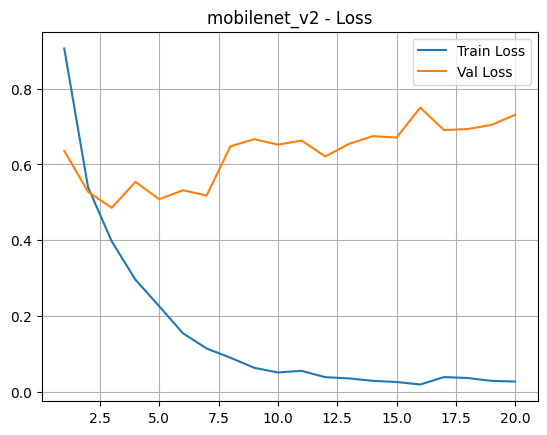

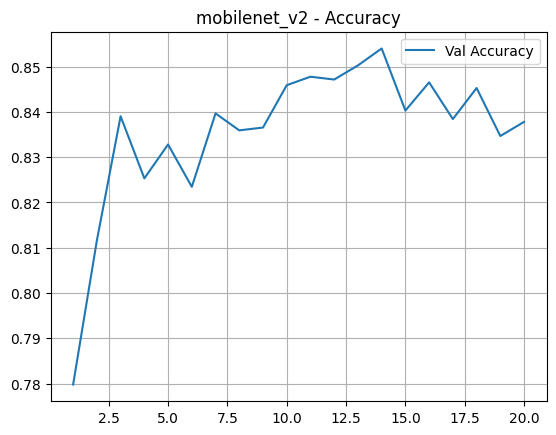

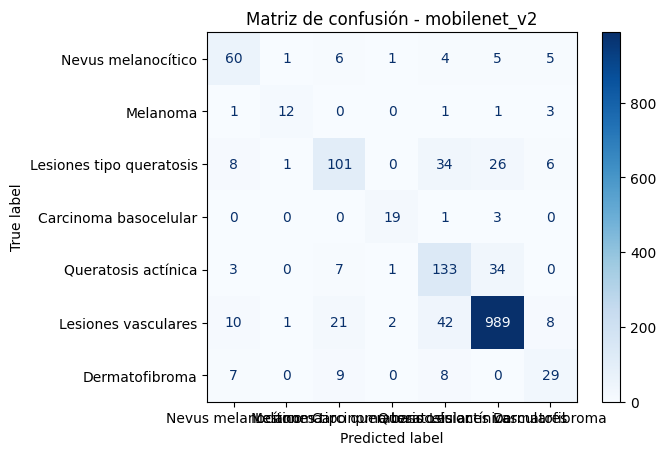

Reporte de clasificación para mobilenet_v2:

                          precision    recall  f1-score   support

      Nevus melanocítico       0.67      0.73      0.70        82
                Melanoma       0.80      0.67      0.73        18
Lesiones tipo queratosis       0.70      0.57      0.63       176
   Carcinoma basocelular       0.83      0.83      0.83        23
     Queratosis actínica       0.60      0.75      0.66       178
     Lesiones vasculares       0.93      0.92      0.93      1073
          Dermatofibroma       0.57      0.55      0.56        53

                accuracy                           0.84      1603
               macro avg       0.73      0.72      0.72      1603
            weighted avg       0.84      0.84      0.84      1603

AUC ROC macro promedio para mobilenet_v2: 0.9632


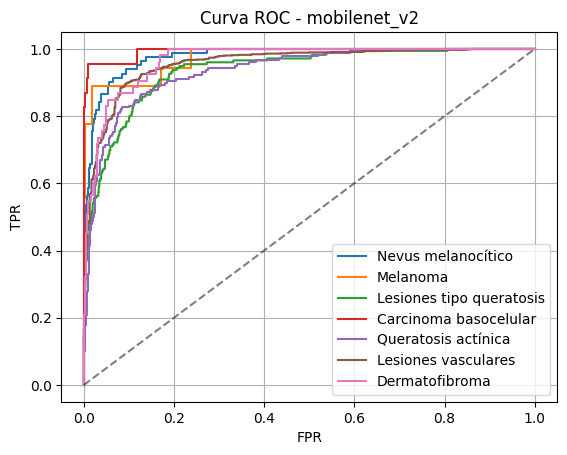

In [12]:
model_name = 'mobilenet_v2'
model = get_model(model_name, num_classes=7)
df_mobilenet = train_model(model, train_loader, val_loader, model_name, epochs=20)
plot_metrics(df_mobilenet, model_name)
report_mobilenet = evaluate_model(model, val_loader, model_name, class_names)

Epoch 1/20 - Train Loss: 0.8081 - Val Loss: 0.5761 - Val Acc: 0.8116
Epoch 2/20 - Train Loss: 0.4422 - Val Loss: 0.5110 - Val Acc: 0.8297
Epoch 3/20 - Train Loss: 0.2780 - Val Loss: 0.4615 - Val Acc: 0.8434
Epoch 4/20 - Train Loss: 0.1918 - Val Loss: 0.4937 - Val Acc: 0.8415
Epoch 5/20 - Train Loss: 0.1322 - Val Loss: 0.5619 - Val Acc: 0.8372
Epoch 6/20 - Train Loss: 0.0920 - Val Loss: 0.4941 - Val Acc: 0.8565
Epoch 7/20 - Train Loss: 0.0792 - Val Loss: 0.5143 - Val Acc: 0.8634
Epoch 8/20 - Train Loss: 0.0520 - Val Loss: 0.5568 - Val Acc: 0.8453
Epoch 9/20 - Train Loss: 0.0542 - Val Loss: 0.5538 - Val Acc: 0.8546
Epoch 10/20 - Train Loss: 0.0537 - Val Loss: 0.5654 - Val Acc: 0.8609
Epoch 11/20 - Train Loss: 0.0445 - Val Loss: 0.5033 - Val Acc: 0.8740
Epoch 12/20 - Train Loss: 0.0390 - Val Loss: 0.6617 - Val Acc: 0.8459
Epoch 13/20 - Train Loss: 0.0319 - Val Loss: 0.5611 - Val Acc: 0.8653
Epoch 14/20 - Train Loss: 0.0351 - Val Loss: 0.5902 - Val Acc: 0.8808
Epoch 15/20 - Train Loss: 0.0

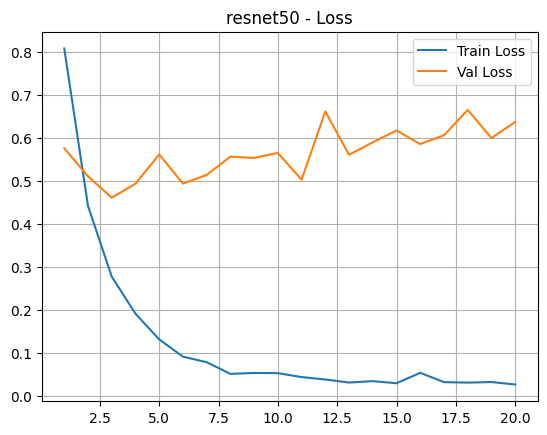

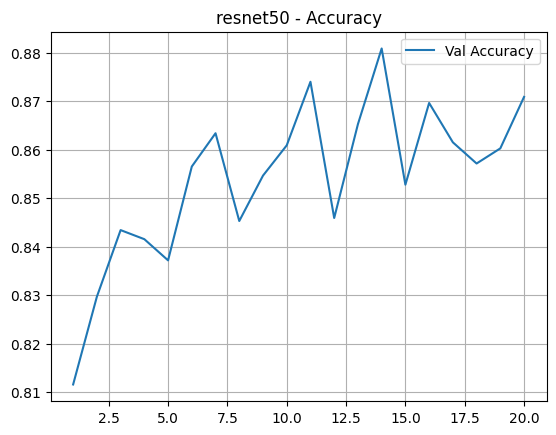

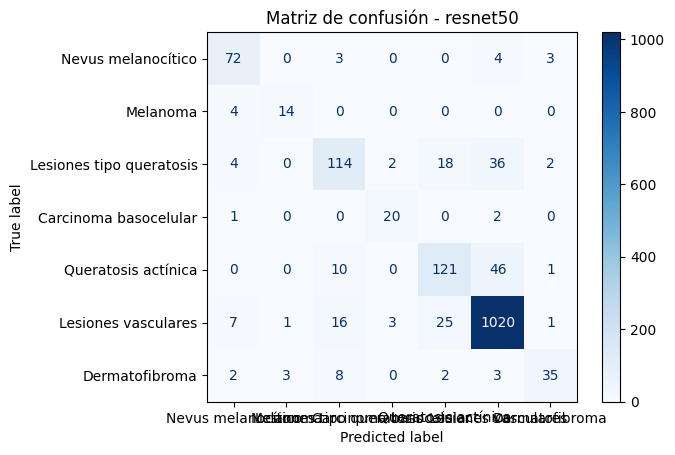

Reporte de clasificación para resnet50:

                          precision    recall  f1-score   support

      Nevus melanocítico       0.80      0.88      0.84        82
                Melanoma       0.78      0.78      0.78        18
Lesiones tipo queratosis       0.75      0.65      0.70       176
   Carcinoma basocelular       0.80      0.87      0.83        23
     Queratosis actínica       0.73      0.68      0.70       178
     Lesiones vasculares       0.92      0.95      0.93      1073
          Dermatofibroma       0.83      0.66      0.74        53

                accuracy                           0.87      1603
               macro avg       0.80      0.78      0.79      1603
            weighted avg       0.87      0.87      0.87      1603

AUC ROC macro promedio para resnet50: 0.9640


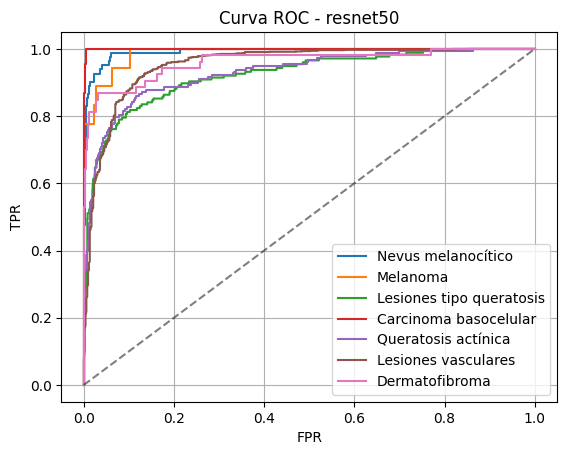

In [14]:
model_name = 'resnet50'
model = get_model(model_name, num_classes=7)
df = train_model(model, train_loader, val_loader, model_name, epochs=20)
plot_metrics(df, model_name)
report_resnet = evaluate_model(model, val_loader, model_name, class_names)

**ANALISIS DE METRICAS DE CADA MODELO**

Durante el proceso de entrenamiento y validación de los modelos EfficientNet-B0, MobileNetV2 y ResNet50, se generaron para cada uno los siguientes gráficos y reportes:

1. Gráficos de pérdida (Loss) y exactitud (Accuracy)
Curvas de Pérdida (Loss):
En cada modelo se graficó la pérdida tanto para el conjunto de entrenamiento como de validación a lo largo de las épocas. Una tendencia decreciente en la pérdida indica que el modelo está aprendiendo correctamente. La estabilización o el aumento de la pérdida de validación puede señalar sobreajuste.

Curvas de Accuracy:
Se registró la evolución de la exactitud (accuracy) en el conjunto de validación durante el entrenamiento. Un aumento sostenido y la posterior estabilización de la accuracy es deseable, mientras que grandes diferencias entre accuracy de entrenamiento y validación pueden sugerir sobreajuste.

2. Matriz de confusión
Para cada modelo se imprimió una matriz de confusión, que permite analizar en detalle cuántas veces el modelo predijo correctamente cada clase y dónde cometió errores.

Las celdas diagonales representan predicciones correctas.

Los valores fuera de la diagonal muestran errores de clasificación (por ejemplo, confundir una lesión benigna con una maligna).

Esto resulta fundamental para detectar si el modelo tiene problemas específicos para distinguir entre ciertas clases, lo cual es especialmente importante en diagnósticos médicos.

3. Métricas por clase
Se calcularon y reportaron métricas como accuracy, F1-score macro y F1-score por clase, brindando una visión más completa del desempeño en cada una de las siete clases de lesiones.
El F1-score es particularmente útil cuando las clases están desbalanceadas, ya que considera tanto la precisión como la sensibilidad.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

!cp results/efficientnet_b0.pth /content/drive/MyDrive/Proyecto_Cancer_Piel/
!cp results/efficientnet_b0_metrics.csv /content/drive/MyDrive/Proyecto_Cancer_Piel/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


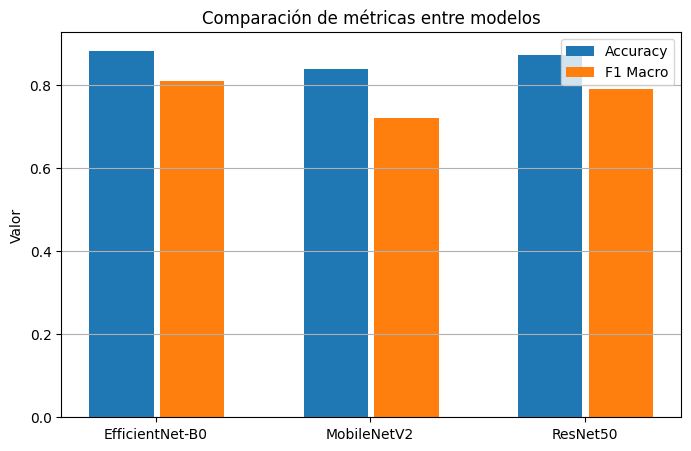

In [17]:
import matplotlib.pyplot as plt

labels = ['EfficientNet-B0', 'MobileNetV2', 'ResNet50']
acc = [
    report_efficientnet['accuracy'],
    report_mobilenet['accuracy'],
    report_resnet['accuracy']
]
f1_macro = [
    report_efficientnet['macro avg']['f1-score'],
    report_mobilenet['macro avg']['f1-score'],
    report_resnet['macro avg']['f1-score']
]
# bal_acc = [bal_acc_efficientnet, bal_acc_mobilenet, bal_acc_resnet] # Ya no se usa

plt.figure(figsize=(8,5))
x = range(len(labels))
plt.bar(x, acc, width=0.3, label='Accuracy', align='center')
plt.bar([i + 0.33 for i in x], f1_macro, width=0.3, label='F1 Macro', align='center')
plt.xticks([i + 0.16 for i in x], labels)
plt.ylabel('Valor')
plt.title('Comparación de métricas entre modelos')
plt.legend()
plt.grid(axis='y')
plt.show()





**CUADRO COMPARATIVO DE METRICAS**

Para comparar objetivamente los tres modelos, se generó un gráfico de barras que muestra los valores de accuracy y F1-score macro para EfficientNet-B0, MobileNetV2 y ResNet50.

Accuracy: Mide la proporción de predicciones correctas sobre el total.

F1 macro: Promedia el F1-score de cada clase, ponderando por igual cada una, sin importar su frecuencia.

Esta visualización permite observar rápidamente cuál modelo logra mejores resultados globales y cuál tiene un rendimiento más equilibrado entre clases.

**JUSTIFICACION DE LA ELECCION**

¿Por qué EfficientNet-B0?

A partir del análisis de los resultados observados en los gráficos y el cuadro comparativo, se puede justificar la elección de EfficientNet-B0 de la siguiente manera:

Mejor desempeño global: EfficientNet-B0 obtuvo los valores más altos de
accuracy y F1-score macro, indicando que no solo acierta en más casos totales, sino que también maneja mejor la clasificación en todas las clases, incluso en aquellas menos representadas.

Generalización: La diferencia entre las métricas de entrenamiento y validación es menor en EfficientNet-B0, lo que evidencia una mejor capacidad de generalización y menor sobreajuste.

Rendimiento en clases críticas: Analizando la matriz de confusión, EfficientNet-B0 muestra menos confusiones en clases de riesgo, como melanoma, lo cual es fundamental en un contexto médico.

Eficiencia: Este modelo, pese a tener menos parámetros que ResNet50, logra un rendimiento superior, lo que lo hace ideal para aplicaciones prácticas que requieran eficiencia en el uso de recursos computacionales.

En resumen, EfficientNet-B0 es el modelo seleccionado porque logra el mejor equilibrio entre desempeño, generalización y eficiencia, siendo la opción más adecuada para la tarea de clasificación de lesiones de piel en el dataset HAM10000.

